In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

In [2]:
def preprocess_(path,  column_, slice='',  encoding=None, header='infer'):

    df = pd.read_csv(path, encoding=encoding, header=header)
    
    if slice:
        df = df[slice]

    df.columns = column_

    if (type(df.iloc[:,1][1])==str):
        df.iloc[:,1] = df.iloc[:,1].apply(lambda x: float(x.replace(',', '')))
        
    df['Date'] = df['Date'].str.replace('[^0-9]', '')
    df['Date'] = df['Date'].apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:])
    df['Date'] = pd.to_datetime(df['Date'])

    df.sort_values('Date', inplace=True)
    df.reset_index(inplace=True)
    df.drop(['index'], axis=1, inplace=True)

    return df

In [4]:
data = preprocess_(path="../datasets/KS200.csv", slice=['Date', 'Close'], column_=['Date', 'KS200'])

len_ = round(len(data)*0.8)
train, target = data[:len_], data[len_:]

C:\Users\dbswo\AppData\Local\Temp\ipykernel_9792\2556062775.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Date'] = df['Date'].str.replace('[^0-9]', '')


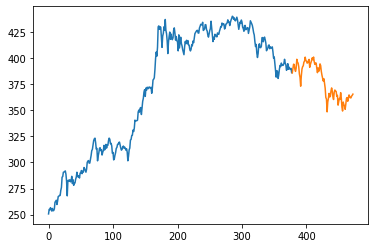

In [7]:
plt.plot(train['KS200'])
plt.plot(target['KS200'])

In [8]:
kpss_diffs = ndiffs(train['KS200'], alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train['KS200'], alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 2


In [9]:
model = pm.auto_arima(y = train['KS200']        # 데이터
                      , d = 2            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2439.034, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2326.127, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2437.039, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2290.970, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2262.662, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=2260.671, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2288.977, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=2182.041, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2180.827, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2178.830, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2177.084, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2178.8

In [10]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  378
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1086.542
Date:                Tue, 26 Apr 2022   AIC                           2177.084
Time:                        17:09:01   BIC                           2184.943
Sample:                             0   HQIC                          2180.204
                                - 378                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9874      0.010   -100.050      0.000      -1.007      -0.968
sigma2        18.7611      1.047     17.926      0.000      16.710      20.812
Ljung-Box (L1) (Q):                   0.34   Jarque-

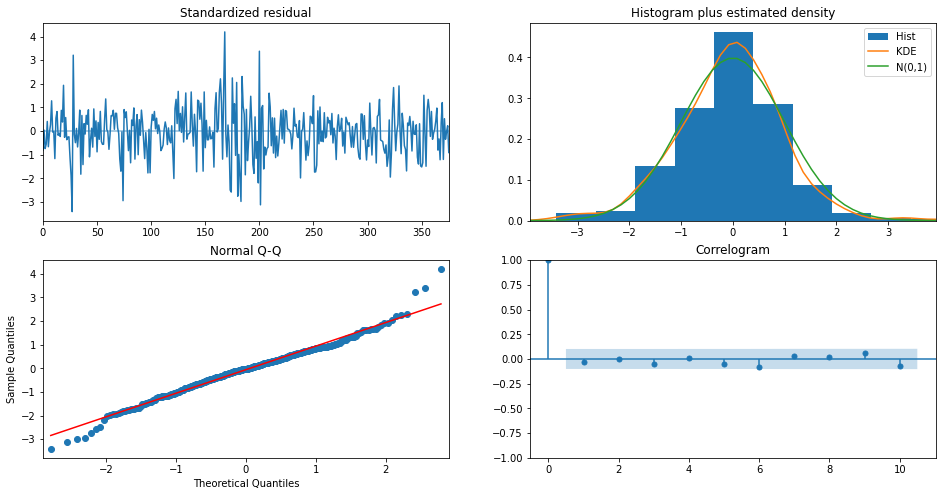

In [11]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

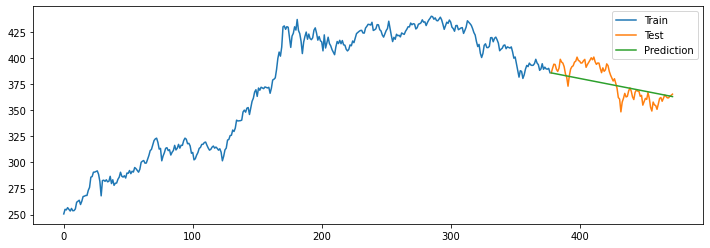

In [12]:
# 테스트 데이터 개수만큼 예측
y_predict = model.predict(n_periods=len(target['KS200'])) 
y_predict = pd.DataFrame(y_predict,index = target['KS200'].index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(train['KS200'], label='Train')        # 훈련 데이터
plt.plot(target['KS200'], label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [13]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [14]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in target['KS200']:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)

In [15]:
pd.DataFrame({"test": target['KS200'], "pred": y_pred})

,test,pred
378,385.97,385.998140
379,390.38,385.727786
380,394.36,390.217245
381,394.07,394.262542
382,389.44,393.970350
...,...,...
468,362.06,363.153627
469,362.06,361.822331
470,363.77,361.824769
471,364.50,363.554836


In [16]:
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  473
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1361.687
Date:                Tue, 26 Apr 2022   AIC                           2727.374
Time:                        17:09:08   BIC                           2735.683
Sample:                             0   HQIC                          2730.643
                                - 473                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9897      0.007   -137.022      0.000      -1.004      -0.976
sigma2        18.8398      0.986     19.113      0.000      16.908      20.772
Ljung-Box (L1) (Q):                   0.06   Jarque-

In [17]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = train['KS200'].index, y = train['KS200'], name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = target['KS200'].index, y = target['KS200'], name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = target['KS200'].index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = target['KS200'].index.tolist() + target['KS200'].index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(0,2,1)모형")
fig.show()

In [18]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(target['KS200'], y_pred):.3f}")
# MAPE: 0.792

MAPE: 0.946
